## Example tracking HARv2

In [1]:
# Import libraries
import iris
import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt
import iris.plot as iplt
import iris.quickplot as qplt
import datetime
import urllib,zipfile,shutil
from netCDF4 import Dataset
import glob
%matplotlib inline
import tobac
from pathlib import Path
import xarray as xr

In [3]:
# Disable a few warnings:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

In [4]:
# update input parameters
from parameters import parameters_features, parameters_segmentation, dt
dxy= 10000
parameters_features['n_min_threshold'] = 10 

In [126]:
# select only one month at the time
savedir = Path('out/')
file = '/media/juli/Data/projects/data/HAR v2_d10km_h_2d_prcp_2018.nc' 

mon= 1
precip= xr.open_dataarray(file)
monthly_precip = precip.sel(time=precip['time.month']== mon)
monthly_precip.to_netcdf('monthly_file.nc')
Precip=iris.load_cube('monthly_file.nc', 'total precipitation (step-wize)')
Precip

<iris 'Cube' of total precipitation (step-wize) / (mm h-1) (time: 744; y-coordinate in Cartesian system: 252; x-coordinate in Cartesian system: 381)>

## Feature detection 

In [127]:
Features= tobac.feature_detection_multithreshold(Precip,dxy,**parameters_features) 
Features.to_hdf(os.path.join(savedir,'Features_HAR_jan.h5'),'table')

## Segmentation 

In [63]:
import segmentation

In [128]:
Mask, Features_cells = segmentation.segmentation_2D(Features, Precip, dxy, **parameters_segmentation)

iris.save([Mask], savedir/ 'Mask_Segmentation_HAR.nc',zlib=True,complevel=4)                
Features_cells.to_hdf(savedir/'Features_cells_HAR.h5','table')

## Basic statistics of results 

Text(0, 0.5, 'number of rain cells')

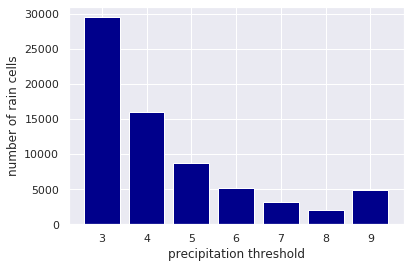

In [65]:
import seaborn as sns 
sns.set()

frequencies, bins = np.histogram(Features_cells.threshold_value.values, bins = np.arange(3,11))

plt.bar(bins[:-1], frequencies, color = 'darkblue')
plt.xlabel('precipitation threshold')
plt.ylabel('number of rain cells')

Text(0, 0.5, 'number of rain cells')

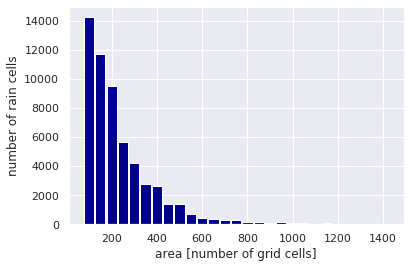

In [66]:
frequencies, bins = np.histogram(Features_cells.ncells.values, bins = np.arange(100,1500,50))

plt.bar(bins[:-1], frequencies, width = 45, color = 'darkblue')
plt.xlabel('area [number of grid cells]')
plt.ylabel('number of rain cells')

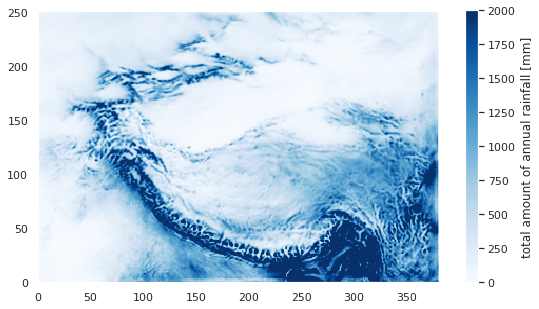

In [69]:
# rainfall amount
plt.figure(figsize=(9,5))
precipsum= np.nansum(Precip.data, axis = 0)
plt.pcolormesh(precipsum, cmap = 'Blues', vmin = 0, vmax = 2000)

cbar=plt.colorbar()
cbar.ax.set_ylabel('total amount of annual rainfall [mm]')
plt.show()

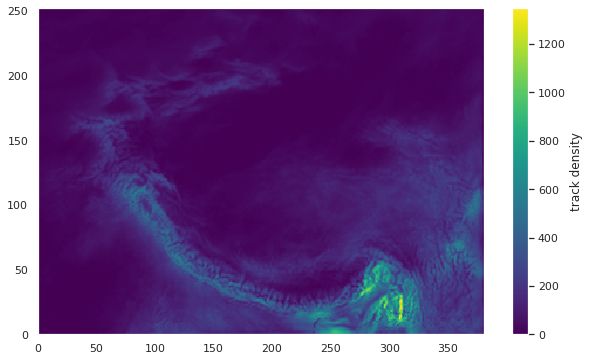

In [70]:
# track density 
plt.figure(figsize=(10,6))
mask= Mask.data
mask[mask > 0] = 1
masksum= np.nansum(mask, axis = 0)
plt.pcolormesh(masksum, cmap = 'viridis')
cbar=plt.colorbar()
cbar.ax.set_ylabel('track density')
plt.show()

## Download data per FTP 

In [4]:
import ftplib


In [11]:
url="ftp.klima.tu-berlin.de"
user="Anonymous"
passw="Anonymous"

In [12]:
FILENAME = 'HAR v2_d10km_h_2d_albedo_2000.nc'    

with ftplib.FTP(url, user,passw) as ftp:
    ftp.cwd('/HAR/V2/d10km/h/2d/')
    with open(FILENAME, 'wb') as f:
        ftp.retrbinary('RETR ' + FILENAME, f.write)

In [14]:
!ls *nc

'HAR v2_d10km_h_2d_albedo_2000.nc'
